<a href="https://colab.research.google.com/github/MarioPasc/GNN/blob/main/GNN_tnbc_genes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# use those exact versions in the installation
!pip install torch-geometric pyg-lib torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.5.1+cu121.html
# install other stuff
!pip install  bravado pandas numpy networkx
!pip install igraph matplotlib cairocffi
# check the installation

from typing import List, Dict, Tuple
import requests
import pandas as pd
import networkx as nx
import torch
import torch_geometric
from torch_geometric.data import Data
from bravado.client import SwaggerClient
import random

import igraph as ig
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(f"PyG version: {torch_geometric.__version__}")



Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 45.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.1 MB/s eta 0:00:00
  Created wheel for bravado-core: filename=bravado_core-6.1.1-py2.py3-none-any.whl size=67675 sha256=b5a7ebbb05dd34721ea98a6e0164bb4375b6b5c04011a19af5ae124a2afc5dd0
  Stored in directory: /root/.cache/pip/wheels/42/35/4a/44ec4c358db21a5d63ed4e40f0f0012a43810

In [41]:
# -------------------------------
# 1. Obtener Red PPI con STRINGdb
# -------------------------------

def get_stringdb_interactions(genes: List[str], species: int = 9606, score_threshold: int = 700) -> pd.DataFrame:
    """
    Obtiene las interacciones proteína-proteína (PPI) para una lista de genes desde STRINGdb.

    Args:
        genes (List[str]): Lista de genes/proteínas.
        species (int): ID de especie (9606 para humanos).
        score_threshold (int): Umbral de score de confianza (0-1000).

    Returns:
        pd.DataFrame: DataFrame con pares de proteínas y su score de interacción.
    """
    url = "https://string-db.org/api/json/network"
    params = {
        "identifiers": "%0d".join(genes),
        "species": species,
        "required_score": score_threshold,
        "limit": 1000
    }
    response = requests.get(url, params=params)
    response.raise_for_status()
    interactions = response.json()

    # Procesar resultados
    data = [{
        "protein1": entry["preferredName_A"],
        "protein2": entry["preferredName_B"],
        "score": entry["score"]
    } for entry in interactions]
    df = pd.DataFrame(data)

    # Filtrar interacciones para que solo incluyan genes en la lista original
    filtered_df = df[(df["protein1"].isin(genes)) & (df["protein2"].isin(genes))]
    return filtered_df

# -------------------------------
# 2. Obtener Vecinos de STRINGdb
# -------------------------------

def get_stringdb_neighbors(genes: List[str], limit: int = 30, species: int = 9606, score_threshold: int = 900) -> pd.DataFrame:
    """
    Expande la red obteniendo los socios de interacción de STRINGdb para los genes especificados.

    Args:
        genes (List[str]): Lista de genes/proteínas iniciales.
        limit (int): Máximo número de socios de interacción por proteína.
        species (int): ID de especie (9606 para humanos).
        score_threshold (int): Umbral de score de confianza (0-1000).

    Returns:
        pd.DataFrame: DataFrame con las interacciones proteína-proteína y scores.
    """
    url = "https://string-db.org/api/json/interaction_partners"
    expanded_interactions = []

    params = {
        "identifiers": genes,
        "species": species,
        "limit": limit,
        "required_score": score_threshold,
        "caller_identity": "my_custom_pipeline"
    }
    response = requests.get(url, params=params)
    response.raise_for_status()
    interactions = response.json()

    for entry in interactions:
        expanded_interactions.append({
            "protein1": entry["preferredName_A"],
            "protein2": entry["preferredName_B"],
            "score": entry["score"]
        })

    return pd.DataFrame(expanded_interactions)

# -------------------------------
# 3. Extraer Datos de Expresión de TCGA
# -------------------------------

def get_tcga_expression_data(genes: List[str], study_id: str = "brca_tcga") -> pd.DataFrame:
    """
    Obtiene datos de expresión génica desde cBioPortal para los genes especificados.

    Args:
        genes (List[str]): Lista de genes de interés.
        study_id (str): ID del estudio de TCGA.

    Returns:
        pd.DataFrame: DataFrame con la expresión génica de cada gen por muestra.
    """
    # Inicializar cliente cBioPortal
    cbioportal = SwaggerClient.from_url(
        'https://www.cbioportal.org/api/v2/api-docs',
        config={"validate_requests": False, "validate_responses": False, "validate_swagger_spec": False}
    )

    # Obtener IDs de los genes
    def get_gene_ids(gene_symbols: List[str]) -> Dict[str, int]:
        response = cbioportal.Genes.fetchGenesUsingPOST(geneIdType="HUGO_GENE_SYMBOL", geneIds=gene_symbols).result()
        return {gene.hugoGeneSymbol: gene.entrezGeneId for gene in response}

    gene_ids = get_gene_ids(genes)
    profile_id = "brca_tcga_rna_seq_v2_mrna_median_Zscores"

    # Extraer datos
    filter_data = {
        'molecularProfileIds': [profile_id],
        'entrezGeneIds': list(gene_ids.values())
    }
    expression_data = cbioportal.Molecular_Data.fetchMolecularDataInMultipleMolecularProfilesUsingPOST(
        molecularDataMultipleStudyFilter=filter_data
    ).result()

    # Formatear resultados
    data = [{
        "sample": d.sampleId,
        "gene": str(d.entrezGeneId),
        "value": float(d.value)
    } for d in expression_data if d.value not in [None, "NA"]]
    df = pd.DataFrame(data)
    df["gene"] = df["gene"].map({str(v): k for k, v in gene_ids.items()})
    return df.pivot(index="sample", columns="gene", values="value")

# -------------------------------
# 4. Formato para PyTorch Geometric
# -------------------------------

import random

def create_pyg_data(ppi_df: pd.DataFrame, expression_df: pd.DataFrame, cancer_genes: List[str], num_random: int = 0) -> tuple:
    """
    Crea un objeto Data de PyTorch Geometric a partir de la red PPI y datos de expresión,
    con un mapeo adicional entre índices y nombres de genes.

    Args:
        ppi_df (pd.DataFrame): DataFrame con interacciones proteicas.
        expression_df (pd.DataFrame): Datos de expresión génica.
        cancer_genes (List[str]): Lista de genes a etiquetar como "1" (cáncer).
        num_random (int): Número de etiquetas a cambiar aleatoriamente de "1" a "0".

    Returns:
        tuple: (Data, dict) - Objeto Data de PyTorch Geometric y un diccionario de mapeo índice -> nombre del gen.
    """
    # Crear lista de nodos y mapping
    nodes = list(expression_df.columns)
    node_map = {gene: i for i, gene in enumerate(nodes)}

    # Crear edge_index
    edges = ppi_df[(ppi_df["protein1"].isin(nodes)) & (ppi_df["protein2"].isin(nodes))]
    edge_index = torch.tensor([
        [node_map[edge["protein1"]], node_map[edge["protein2"]]]
        for _, edge in edges.iterrows()
    ]).t().contiguous()

    # Crear matriz de features
    x = torch.tensor(expression_df.T.values, dtype=torch.float)

    # Crear etiquetas: "1" para genes en cancer_genes, "-1" para los demás
    y = torch.tensor([1 if gene in cancer_genes else -1 for gene in nodes], dtype=torch.long)

    # Modificar aleatoriamente etiquetas si num_random > 0
    if num_random > 0:
        # Identificar índices de nodos etiquetados como 1
        labeled_indices = (y == 1).nonzero(as_tuple=True)[0].tolist()

        # Seleccionar aleatoriamente num_random índices
        num_random = min(num_random, len(labeled_indices))
        random_indices = random.sample(labeled_indices, num_random)

        # Cambiar etiquetas seleccionadas a 0
        for idx in random_indices:
            y[idx] = 0

        print(f"Se cambiaron aleatoriamente {num_random} etiquetas de '1' a '0'.")

    # Crear mapeo índice -> nombre del gen
    index_to_gene = {i: gene for gene, i in node_map.items()}

    return Data(x=x, edge_index=edge_index, y=y), index_to_gene


def filter_ppi_for_expression(ppi_df: pd.DataFrame, expression_genes: List[str]) -> pd.DataFrame:
    """
    Filtra las interacciones PPI para que solo incluyan genes presentes en los datos de expresión.

    Args:
        ppi_df (pd.DataFrame): DataFrame de interacciones PPI.
        expression_genes (List[str]): Lista de genes presentes en la matriz de expresión.

    Returns:
        pd.DataFrame: DataFrame filtrado con interacciones válidas.
    """
    filtered_df = ppi_df[(ppi_df["protein1"].isin(expression_genes)) & (ppi_df["protein2"].isin(expression_genes))]
    return filtered_df


# BiologyGNN

In [21]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import networkx as nx
import numpy as np

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Add this at the start of your main code
set_seed(42)  # or any other number

class BiologyGNN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes, hidden_channels=64):
        super(BiologyGNN, self).__init__()

        # Graph Convolutional layers
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)

        # Output layer
        self.linear = nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        # First Graph Convolution Layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.1, training=self.training)

        # Second Graph Convolution Layer
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.1, training=self.training)

        # Third Graph Convolution Layer
        x = self.conv3(x, edge_index)
        x = F.relu(x)

        # Output Layer
        x = self.linear(x)

        return F.log_softmax(x, dim=1)

def create_example_dataset():
    """Create a simple example biological network dataset"""
    # Create a random graph
    G = nx.random_geometric_graph(20, 0.3)

    # Convert to edge index format
    edge_index = torch.tensor([[e[0] for e in G.edges()],
                             [e[1] for e in G.edges()]], dtype=torch.long)

    # Create random node features (could represent gene expression, protein properties, etc.)
    num_node_features = 10
    x = torch.randn((20, num_node_features))

    # Create random node labels (could represent protein function, pathway membership, etc.)
    y = torch.randint(0, 3, (20,))

    # Create PyG Data object
    data = Data(x=x, edge_index=edge_index, y=y)
    return data

def train_model(model, data, epochs=100):
    """
    Entrena el modelo GNN utilizando una máscara para ignorar nodos con etiqueta desconocida (-1).

    Args:
        model: Modelo BiologyGNN.
        data: Objeto Data de PyTorch Geometric.
        epochs (int): Número de épocas de entrenamiento.
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # Máscara para filtrar etiquetas conocidas (y != -1)
    train_mask = data.y != -1
    train_y = data.y[train_mask]  # Etiquetas conocidas

    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()

        # Forward
        out = model(data.x, data.edge_index)

        # Filtrar predicciones para nodos conocidos
        out_masked = out[train_mask]

        # Calcular pérdida solo en nodos con etiquetas conocidas
        loss = F.nll_loss(out_masked, train_y)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1:03d}, Loss: {loss:.4f}')




#### Evaluate the model



def evaluate_model(model, data):
    """
    Evalúa el modelo prediciendo las etiquetas para los nodos con etiquetas desconocidas (-1).

    Args:
        model: Modelo BiologyGNN.
        data: Objeto Data de PyTorch Geometric.
    """
    model.eval()
    with torch.no_grad():
        # Obtener predicciones
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)

        # Filtrar nodos desconocidos (originalmente etiquetados como -1)
        unknown_mask = data.y == -1
        predicted_unknown = pred[unknown_mask]

        print("\nPredicted Classes for Unknown Nodes:")
        print(predicted_unknown)


In [42]:

# -------------------------------
# 5. Pipeline General
# -------------------------------

"""
Pipeline general para obtener la red PPI, expandirla, extraer datos de expresión y crear el objeto PyG Data.
"""
genes = ["TP53", "PIK3CA", "RB1", "BRCA1", "PTEN", "ATM", "EGFR", "BRAF", "BRCA2", "AKT1",
          "PIK3R1", "KDR", "NF1", "ERBB4", "JAK2", "NOTCH1", "TRRAP", "MET", "ALK", "CDKN2A"]
ppi_df = get_stringdb_interactions(genes)
expanded_ppi_df = get_stringdb_neighbors(genes)
combined_ppi_df = pd.concat([ppi_df, expanded_ppi_df]).drop_duplicates()

combined_genes = list(set(combined_ppi_df["protein1"]).union(set(combined_ppi_df["protein2"])))
expression_df = get_tcga_expression_data(combined_genes)

# Filtrar interacciones
expression_genes = expression_df.columns.tolist()
filtered_ppi_df = filter_ppi_for_expression(ppi_df, expression_genes) # Nos quitamos genes que hayamos traído que no se tengan los valores de expresión

combined_ppi_df.to_csv("combined_ppi.csv", index=False)
expression_df.to_csv("expression_data.csv", index=False)

# Crear objeto PyTorch Geometric Data
data, mapping = create_pyg_data(filtered_ppi_df, expression_df, genes, num_random=6)

# Inicializar modelo con características reales
num_node_features = data.x.size(1)
num_classes = len(data.y.unique())
model = BiologyGNN(num_node_features=num_node_features, num_classes=num_classes)

# Entrenar modelo
train_model(model, data)

# Hacer predicciones
model.eval()
pred = model(data.x, data.edge_index)
predicted_classes = pred.argmax(dim=1)
print("\nPredicted classes:", predicted_classes)


Se cambiaron aleatoriamente 6 etiquetas de '1' a '0'.
Epoch 010, Loss: 0.6988
Epoch 020, Loss: 0.6347
Epoch 030, Loss: 0.5258
Epoch 040, Loss: 0.4291
Epoch 050, Loss: 0.5131
Epoch 060, Loss: 0.2633
Epoch 070, Loss: 0.6192
Epoch 080, Loss: 0.3552
Epoch 090, Loss: 0.4184
Epoch 100, Loss: 0.2404

Predicted classes: tensor([0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])


In [28]:
for gene in combined_genes:
  print(f"Gene {gene} IS NOT in the expression matrix ❌") if gene not in expression_df.columns.tolist() else print(f"Gene {gene} IS in the expression matrix ✅")

Gene RB1 IS in the expression matrix ✅
Gene MDM4 IS in the expression matrix ✅
Gene EGFR IS in the expression matrix ✅
Gene MET IS in the expression matrix ✅
Gene NF1 IS in the expression matrix ✅
Gene CHEK2 IS in the expression matrix ✅
Gene NOTCH1 IS in the expression matrix ✅
Gene PIK3R1 IS in the expression matrix ✅
Gene TP53 IS in the expression matrix ✅
Gene ATM IS in the expression matrix ✅
Gene CDKN1A IS in the expression matrix ✅
Gene BRAF IS in the expression matrix ✅
Gene USP7 IS in the expression matrix ✅
Gene CREBBP IS in the expression matrix ✅
Gene TRRAP IS in the expression matrix ✅
Gene KDR IS in the expression matrix ✅
Gene TP53BP1 IS in the expression matrix ✅
Gene RAD51 IS in the expression matrix ✅
Gene PTEN IS in the expression matrix ✅
Gene ALK IS in the expression matrix ✅
Gene CREB1 IS in the expression matrix ✅
Gene SFN IS in the expression matrix ✅
Gene HSP90AA1 IS in the expression matrix ✅
Gene JAK2 IS in the expression matrix ✅
Gene CDKN2A IS in the expres

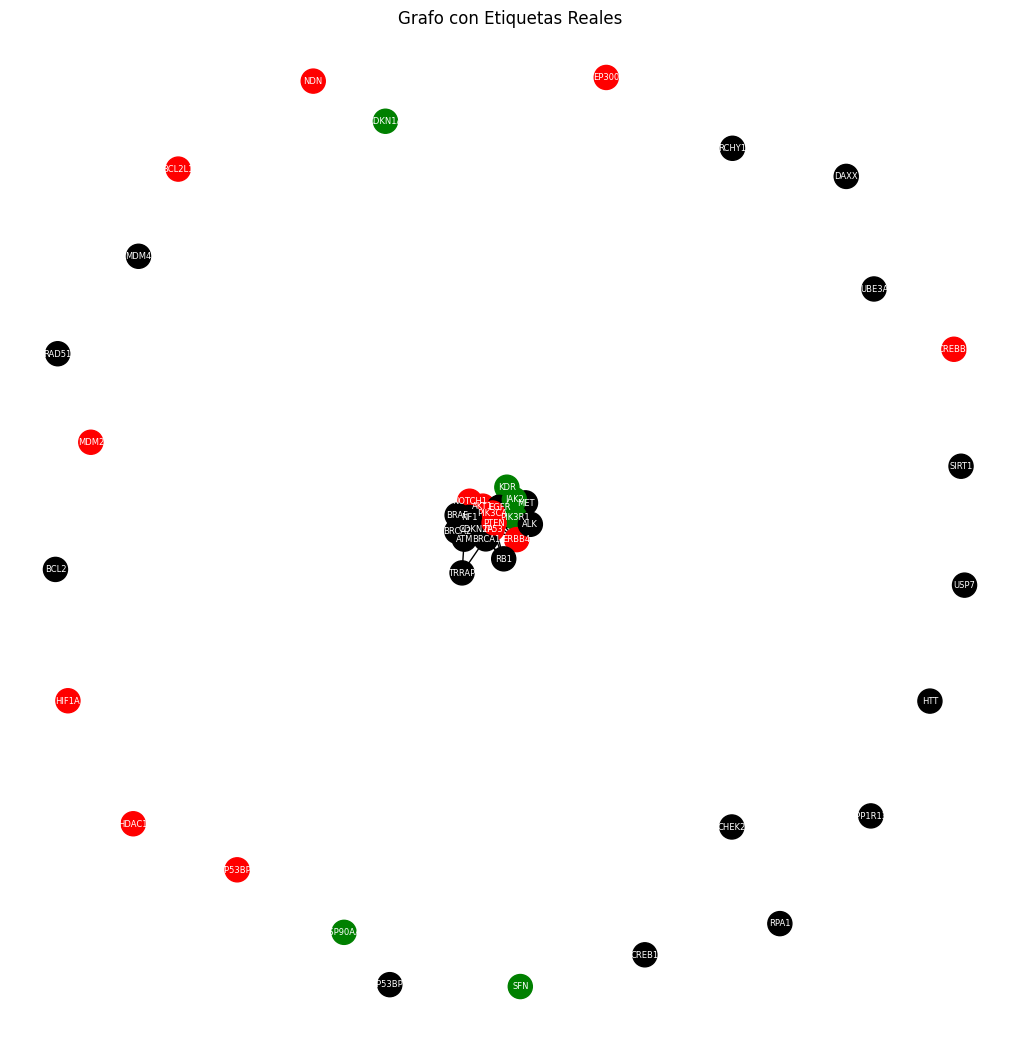

In [44]:
import networkx as nx
import matplotlib.pyplot as plt
def visualize_pyg_data(data, index_to_gene, title="Graph Visualization", predictions=None):
    """
    Visualiza un grafo a partir de un objeto PyTorch Geometric Data.

    Args:
        data (torch_geometric.data.Data): Objeto de datos de PyTorch Geometric.
        index_to_gene (dict): Diccionario de mapeo índice -> nombre del gen.
        title (str): Título de la visualización.
        predictions (torch.Tensor): Etiquetas predichas para los nodos (opcional).
    """
    # Crear un grafo NetworkX desde edge_index
    G = nx.Graph()
    edge_list = data.edge_index.t().tolist()
    G.add_edges_from(edge_list)

    # Crear nodos explícitamente
    node_indices = list(range(data.y.size(0)))
    G.add_nodes_from(node_indices)

    # Determinar colores de los nodos
    labels = predictions if predictions is not None else data.y
    color_map = ["red" if labels[i] == 1 else "green" if labels[i] == 0 else "black" for i in range(len(labels))]

    # Obtener etiquetas (nombres de los genes)
    node_labels = {i: index_to_gene[i] for i in node_indices}

    # Visualizar el grafo
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(
        G,
        pos,
        node_color=color_map,
        with_labels=True,
        labels=node_labels,  # Usar nombres de genes como etiquetas
        node_size=300,
        font_size=6,
        font_color="white"
    )
    plt.title(title)
    plt.show()


# Visualizar etiquetas reales
visualize_pyg_data(data, title="Grafo con Etiquetas Reales", index_to_gene=mapping)


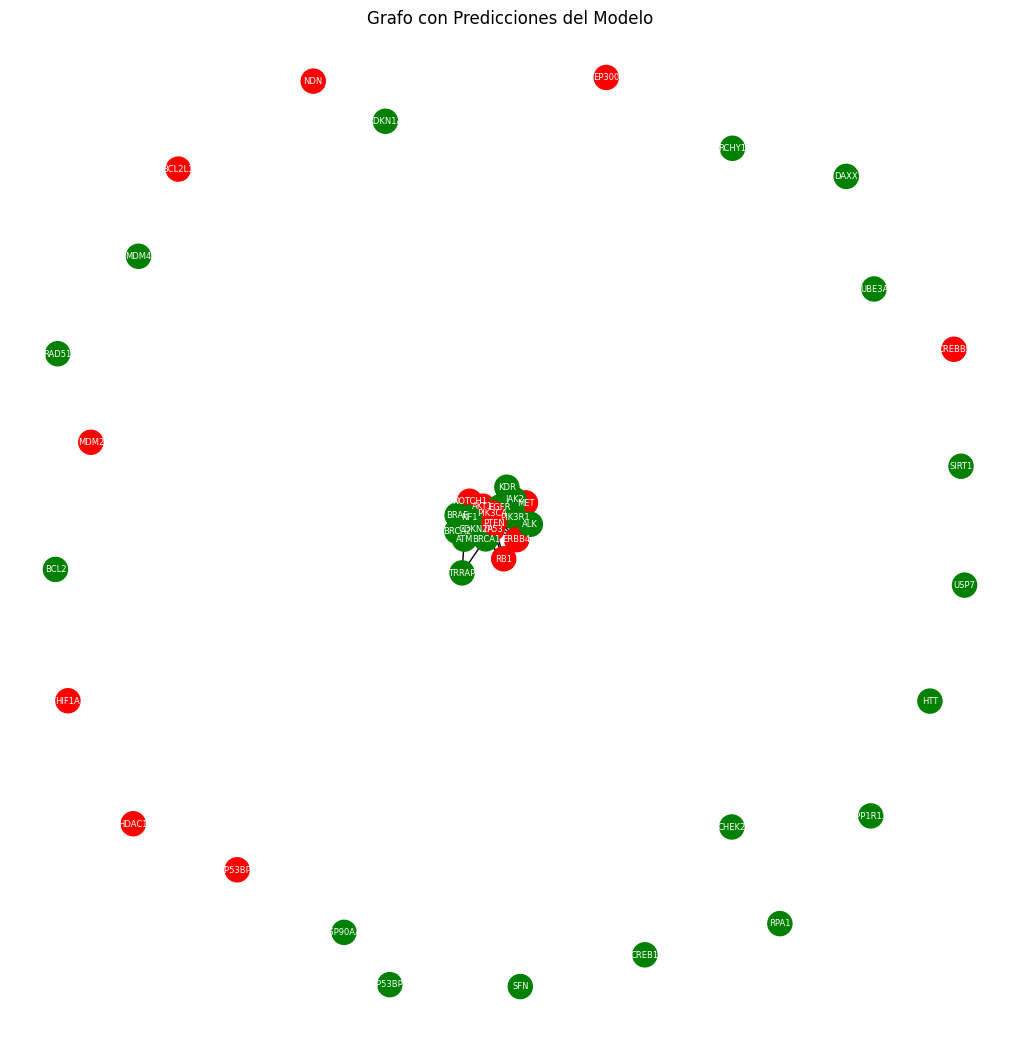

In [45]:
# Obtener predicciones del modelo
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    predictions = out.argmax(dim=1)

# Visualizar predicciones
visualize_pyg_data(data, title="Grafo con Predicciones del Modelo", predictions=predictions, index_to_gene=mapping)
